In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.geometry import (
    estimate_intrinsic_from_homography,
    recover_pose_from_homography,
)
from src.measurement_data import load_measurements_from_yaml
from src.plotting import draw_3d_axes

In [3]:
data = load_measurements_from_yaml("../assets/measurements.yaml")

In [4]:
# Pretty print everything
data.print_overview()

=== Measurement Data Overview ===

[Unit]: mm

--- Templates (2 total) ---
[T1] DA Card
* path:   assets/templates/template_00.jpg
* (w, h): 85.0×55.0

[T2] Bookmark
* path:   assets/templates/template_01.jpg
* (w, h): 50.0×180.0


--- Scenes (5 total) ---
[S1] Frontal Bookmark
* path: assets/images/scene_00.jpg
* distances:
	Camera <-> T2 = 390.0

[S2] Frontal DA Card - Far
* path: assets/images/scene_01.jpg
* distances:
	Camera <-> T1 = 490.0

[S3] Frontal DA Card - Close
* path: assets/images/scene_02.jpg
* distances:
	Camera <-> T1 = 225.0

[S4] Both templates - Angled View
* path: assets/images/scene_03.jpg
* distances:
	Camera <-> T1 = 330.0
	Camera <-> T2 = 380.0

[S5] Both templates - Another Angle
* path: assets/images/scene_04.jpg
* distances:
	Camera <-> T1 = 360.0
	Camera <-> T2 = 260.0
	T1 <-> T2 = 190.0




In [5]:
# Load scene 1 and template 2
scene = data.get_scene("S4")
template = data.get_template("T1")

scene_path = os.path.join(project_root, scene.path)
template_path = os.path.join(project_root, template.path)

scene_image = cv2.cvtColor(cv2.imread(scene_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
template_image = cv2.cvtColor(cv2.imread(template_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

## Homography from pixels, then scaling

In [6]:
def detect_template_regions(template, images, image_paths, max_matches=50):
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    print("[INFO] Extracting SIFT keypoints...")
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
    print(f" - Template: {len(keypoints_template)} keypoints")

    visual_results = []
    return_data = []

    for idx, (image, path) in enumerate(zip(images, image_paths)):
        keypoints_image, descriptors_image = sift.detectAndCompute(image, None)
        image_name = path.split('/')[-1]
        print(f" - {image_name}: {len(keypoints_image)} keypoints")

        matches = bf.match(descriptors_template, descriptors_image)
        matches = sorted(matches, key=lambda x: x.distance)
        print(f"\n[INFO] {len(matches)} raw matches found")

        if len(matches) >= 4:
            M, mask = compute_homography(matches, keypoints_template, keypoints_image)
            if M is not None:
                inliers = int(np.sum(mask))
                print(f"[INFO] Homography computed with {inliers} inliers")
                image_out = draw_rectangle(image, M, template.shape[:2])
                image_out = draw_inliers(image_out, matches, mask, keypoints_image)
            else:
                print("[ERROR] Homography computation failed")
                image_out = image.copy()
                mask = None
        else:
            print("[WARNING] Not enough matches to compute homography")
            M = None
            mask = None
            image_out = image.copy()
        print()

        visual_results.append((image_name, image_out))
        return_data.append({
            'image': image_name,
            'homography': M,
            'mask': mask
        })

    print("\n📦 Plotting detected regions...\n")
    fig, axes = plt.subplots(1, len(visual_results), figsize=(5 * len(visual_results), 5))
    if len(visual_results) == 1:
        axes = [axes]
    for ax, (name, image_out) in zip(axes, visual_results):
        ax.imshow(image_out)
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return return_data

def compute_homography(matches, keypoints1, keypoints2):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M, mask

def draw_rectangle(image, M, template_shape):
    h, w = template_shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    return cv2.polylines(image.copy(), [np.int32(dst)], isClosed=True, color=(255, 0, 0), thickness=3)

def draw_inliers(image, matches, mask, keypoints):
    # Draw circles on the inliers
    inliers = [m for i, m in enumerate(matches) if mask[i]]
    for m in inliers:
        pt = keypoints[m.trainIdx].pt
        cv2.circle(image, (int(pt[0]), int(pt[1])), 5, (0, 255, 0), -1)
    return image

[INFO] Extracting SIFT keypoints...
 - Template: 616 keypoints
 - scene_03.jpg: 894 keypoints

[INFO] 171 raw matches found
[INFO] Homography computed with 96 inliers


📦 Plotting detected regions...



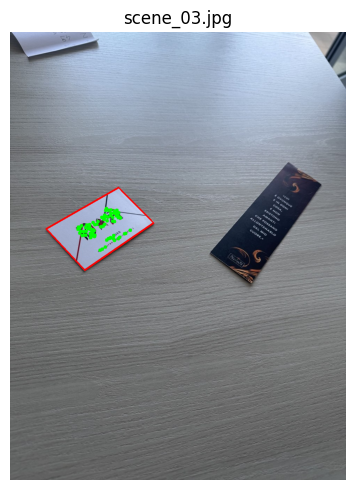

In [7]:
# Compute homography and draw rectangle
results = detect_template_regions(template_image, [scene_image], [scene_path], max_matches=50)

In [8]:
H = results[0]['homography']
mask = results[0]['mask']

print(H)
print(f"Mask length: {len(mask)}")

[[ 2.81217265e-01  1.84017089e-01  1.03228638e+02]
 [-6.66410704e-02  1.79077565e-01  5.62799893e+02]
 [ 1.51765080e-04 -3.64877161e-05  1.00000000e+00]]
Mask length: 171


In [9]:
# Define known camera intrinsics
ux = scene_image.shape[1] / 2
uy = scene_image.shape[0] / 2

# Estimate K using the homography matrix
K = estimate_intrinsic_from_homography(H, (ux, uy))

# Recover the pose using the homography matrix and camera intrinsics
R, t = recover_pose_from_homography(H, K)

[WARN] Original homography columns may not be orthogonal: normalized dot = 0.537
[INFO] f_squared (orthogonality constraint): 1596551.50140855
[INFO] f_squared (norm constraint): 523180.4806277194
[INFO] Using average of both estimates (they are consistent)


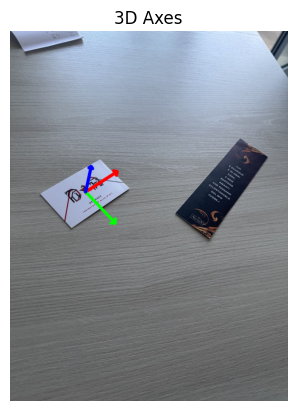

In [10]:
t_shape = template_image.shape[:2]

# Draw 3D axes
img = draw_3d_axes(scene_image, R, t, K, template_shape=t_shape)

# Plot the image with 3D axes
plt.show()
plt.imshow(img)
plt.title("3D Axes")
plt.axis('off')
plt.show()

In [11]:
def compute_distance_grid(R, t_unscaled, width, height):
    """
    Compute the distances from the camera center to a 3x3 grid of real-world points on a planar template.

    Parameters:
        R (np.ndarray): 3x3 rotation matrix from template to camera
        t_unscaled (np.ndarray): 3x1 translation vector (unscaled, from homography decomposition)
        width (float): Template width in real-world units (e.g., mm)
        height (float): Template height in real-world units (e.g., mm)

    Returns:
        np.ndarray: 3x3 array of distances from the camera to each of the 9 grid points
    """

    # Define two points in the template's local coordinate system (known real-world distance between them)
    p_world1 = np.array([[0], [0], [0]])          # Top-left corner
    p_world2 = np.array([[width], [0], [0]])      # Top-right corner

    # Transform both into the camera coordinate system using unscaled t
    p_cam1 = R @ p_world1 + t_unscaled
    p_cam2 = R @ p_world2 + t_unscaled

    # Compute the distance between the transformed points
    cam_distance = np.linalg.norm(p_cam2 - p_cam1)

    # Compute scale factor to align camera space with real-world distance
    real_distance = width
    scale = real_distance / cam_distance

    # Apply scale to the translation vector
    t_scaled = t_unscaled * scale

    print(f"Scale factor: {scale}")
    print(f"Original ||t||: {np.linalg.norm(t_unscaled)}")
    print(f"Scaled ||t||: {np.linalg.norm(t_scaled)}")

    # 3x3 grid: corners, midpoints, center
    x_vals = [0, width / 2, width]
    y_vals = [0, height / 2, height]

    distances = np.zeros((3, 3))

    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            pt_world = np.array([[x], [y], [0]])  # in template frame
            pt_cam = R @ pt_world + t_scaled      # in camera frame
            dist = np.linalg.norm(pt_cam)
            distances[i, j] = dist

    return distances

In [12]:
# Width and height in real-world units (e.g., mm)
width = template.width
height = template.height

dist_grid = compute_distance_grid(R, t, width, height)
print(np.round(dist_grid, 2))

Scale factor: 0.5773502691896251
Original ||t||: 3689.3975623767005
Scaled ||t||: 2130.0746757857346
[[3689.4  3698.25 3708.54]
 [3700.17 3709.   3719.26]
 [3711.53 3720.33 3730.56]]


In [13]:
# Known template size in mm
template_width = template.width
template_height = template.height

# Real-world coordinates of template corners (Z=0)
# Order: top-left, top-right, bottom-right, bottom-left
template_corners_world = np.array([
    [0, 0],
    [template_width, 0],
    [template_width, template_height],
    [0, template_height]
], dtype=np.float32)

# Corresponding image points detected via template matching (e.g., cv2.findHomography)
# This should be obtained from your actual detection
template_corners_image = np.array([
    [535, 300],
    [800, 310],
    [795, 610],
    [530, 600]
], dtype=np.float32)

# Step 1: Compute homography from world (template) to image
H, _ = cv2.findHomography(template_corners_world, template_corners_image)

# Step 2: Decompose homography to [R|t]
H = H / H[-1, -1]
K_inv = np.linalg.inv(K)
B = K_inv @ H

# Normalize rotation vectors
lambda_ = 1 / np.linalg.norm(B[:, 0])
r1 = lambda_ * B[:, 0]
r2 = lambda_ * B[:, 1]
t = lambda_ * B[:, 2]
r3 = np.cross(r1, r2)

R = np.stack((r1, r2, r3), axis=1)

# Ensure R is a proper rotation matrix (optional: enforce orthogonality via SVD)
U, _, Vt = np.linalg.svd(R)
R = U @ Vt

# Step 3: Compute center of template in world coordinates
template_center_world = np.array([template_width / 2, template_height / 2, 0.0])

# Step 4: Transform template center to camera coordinates
template_center_cam = R @ template_center_world + t

# Step 5: Compute distance from camera center (origin) to template center
distance_mm = np.linalg.norm(template_center_cam)

print(f"Distance from camera to template center: {distance_mm:.2f} mm")

Distance from camera to template center: 344.81 mm


In [14]:
import cv2
import numpy as np


def compute_distance_from_homography(H_matrix, K_matrix, template_real_length_mm=None, template_pixel_length=None):
    """
    Computes the distance of the template origin to the camera center
    using a homography matrix and camera intrinsics.

    The homography H maps points from the template's planar coordinate system
    (where Z_template=0) to the image plane. The decomposition H = K [r1 r2 t]
    yields the rotation (r1, r2, r3=r1xr2) and translation (t) that transform
    points from the template's coordinate system to the camera's coordinate system.
    The distance to the template's origin is then the magnitude of t.

    Args:
        H_matrix (np.ndarray): The 3x3 homography matrix.
                               It should be a NumPy array of type float64.
        K_matrix (np.ndarray): The 3x3 camera intrinsic matrix.
                               It should be a NumPy array of type float64.
        template_real_length_mm (float, optional): A known real-world length on the template, in millimeters.
                                                   e.g., the side length of a square. Required for scaling.
        template_pixel_length (float, optional): The corresponding length in pixels in the template's
                                                 own coordinate system (used when the homography was computed).
                                                 Required for scaling.

    Returns:
        float: The calculated distance from the camera center to the template's origin.
               The units of the distance will be consistent with the units of
               `template_real_length_mm`. Returns None if no valid pose solution is found
               or an error occurs, or if scaling information is incomplete.
    """
    # Ensure input matrices are numpy arrays of type float64, as expected by OpenCV
    H = np.array(H_matrix, dtype=np.float64)
    K = np.array(K_matrix, dtype=np.float64)

    if H.shape != (3, 3):
        print("Error: Homography matrix H must be 3x3.")
        return None
    if K.shape != (3, 3):
        print("Error: Camera intrinsic matrix K must be 3x3.")
        return None

    try:
        # Decompose the homography matrix to get rotations, translations, and normals
        num_solutions, rotations, translations, normals = cv2.decomposeHomographyMat(H, K)
        print(f"Found {num_solutions} possible solutions to the homography decomposition")
    except cv2.error as e:
        print(f"OpenCV error during decomposeHomographyMat: {e}")
        print("This might indicate a degenerate homography (e.g., pure rotation, non-planar scene, or poor matches).")
        return None
    except Exception as e: # Catch other potential errors, e.g., from older OpenCV versions
        print(f"An unexpected error occurred during decomposeHomographyMat: {e}")
        return None

    # Store candidate solutions that satisfy disambiguation criteria
    candidate_solutions = []

    for i in range(num_solutions):
        t_vec = translations[i].flatten()  # Translation vector t = [tx, ty, tz]^T
        n_vec = normals[i].flatten()       # Normal vector n = [nx, ny, nz]^T

        # --- Disambiguation Criteria ---

        # 1. Cheirality: Template origin must be in front of the camera.
        #    The z-component of the translation vector (t_z) must be positive.
        #    A small epsilon is used for robust floating-point comparison.
        if t_vec[2] <= 1e-6:
            # continue  # This solution places the object behind or at the camera plane
            pass

        # 2. Plane Normal: The normal of the plane (in camera coordinates) should
        #    indicate that the plane is oriented towards the camera.
        #    A common heuristic is that the z-component of this normal (n_z) is positive.
        #    This assumes the normal vector points from the plane into the half-space
        #    containing the camera.
        if n_vec[2] <= 1e-6:
            continue # This solution suggests the plane is facing away or is edge-on

        # If both criteria are met, this is a potential candidate
        candidate_solutions.append({'translation': t_vec, 'normal_z': n_vec[2]})
        # We store 'normal_z' to pick the "best" among multiple candidates later.

    if not candidate_solutions:
        print("No valid pose solution found after applying disambiguation criteria.")
        print("Possible reasons: incorrect homography, incorrect camera intrinsics, or object not visible as expected.")
        return None

    # If multiple valid solutions exist, select the one most likely to be correct.
    # A common strategy is to choose the solution whose plane normal's z-component (n_z)
    # is the largest (i.e., the plane is most "front-facing" to the camera's Z-axis).
    if len(candidate_solutions) > 1:
        # Sort solutions by n_z in descending order
        candidate_solutions.sort(key=lambda s: s['normal_z'], reverse=True)
        # print(f"Multiple ({len(candidate_solutions)}) valid solutions found. Selected the one with max n_z.")

    # The best solution is the first one after sorting (or the only one if len was 1)
    best_t = candidate_solutions[0]['translation']

    # Apply scaling if provided
    if template_real_length_mm is not None and template_pixel_length is not None:
        if template_pixel_length <= 0:
            print("Error: template_pixel_length must be positive for scaling.")
            return None
        scale_factor = template_real_length_mm / template_pixel_length
        best_t_scaled = best_t * scale_factor
        print(f"Applied scaling factor: {scale_factor:.4f} mm/pixel")
        distance = np.linalg.norm(best_t_scaled)
        print("Norm of all possible translation vectors found by decomposeHomographyMat (before scaling):")
        for t in translations:
            print(np.linalg.norm(t.flatten()))
    else:
        print("Warning: Real-world template measurements and pixel length not provided. Distance will be in units consistent with how the homography's source points were defined (e.g., template image pixels).")
        print("Norm of all possible translation vectors found by decomposeHomographyMat:")
        for t in translations:
            print(np.linalg.norm(t.flatten()))
        distance = np.linalg.norm(best_t)

    return distance

In [15]:
# Compute distance
distance = compute_distance_from_homography(H, K, template_real_length_mm=template.width, template_pixel_length=template_image.shape[1])
print(f"Distance from camera to template origin: {distance:.2f} mm")

Found 4 possible solutions to the homography decomposition
Applied scaling factor: 0.0962 mm/pixel
Norm of all possible translation vectors found by decomposeHomographyMat (before scaling):
1.6586088416983862
1.6586088416983862
1.6586088416983849
1.6586088416983849
Distance from camera to template origin: 0.16 mm


In [16]:
10147.89 * 0.0962

976.2270179999999

## Compute homography from real world measurements

In [17]:
def compute_homography_from_template_real_world(
    template_img_path: str,
    scene_img_path: str,
    template_width_mm: float,
    template_height_mm: float,
    feature_detector_type: str = 'SIFT',
    min_matches: int = 10,
    ransac_reproj_threshold: float = 5.0
) -> np.ndarray | None:
    """
    Computes the homography matrix that maps real-world coordinates of a template
    to pixel coordinates in a scene image.

    Args:
        template_img_path (str): Path to the template image file.
        scene_img_path (str): Path to the scene image file containing an instance of the template.
        template_width_mm (float): The real-world width of the template in millimeters.
        template_height_mm (float): The real-world height of the template in millimeters.
        feature_detector_type (str): Type of feature detector to use ('ORB', 'SIFT', 'AKAZE').
                                     Note: SIFT requires opencv-contrib-python.
        min_matches (int): Minimum number of good matches required to compute a homography.
        ransac_reproj_threshold (float): Maximum allowed reprojection error to treat a point pair
                                         as an inlier for RANSAC.

    Returns:
        np.ndarray: The 3x3 homography matrix (np.float64), mapping template
                    real-world coordinates to scene image pixel coordinates.
                    Returns None if homography cannot be computed (e.g., not enough matches).
    """
    # 1. Load Images
    template_img = cv2.imread(template_img_path, cv2.IMREAD_GRAYSCALE)
    scene_img = cv2.imread(scene_img_path, cv2.IMREAD_GRAYSCALE)

    if template_img is None:
        print(f"Error: Could not load template image from {template_img_path}")
        return None
    if scene_img is None:
        print(f"Error: Could not load scene image from {scene_img_path}")
        return None

    # 2. Initialize Feature Detector and Descriptor Extractor
    if feature_detector_type.upper() == 'ORB':
        detector = cv2.ORB_create()
    elif feature_detector_type.upper() == 'SIFT':
        try:
            detector = cv2.SIFT_create()
        except AttributeError:
            print("Error: SIFT not available. Install opencv-contrib-python if needed.")
            return None
    elif feature_detector_type.upper() == 'AKAZE':
        detector = cv2.AKAZE_create()
    else:
        print(f"Error: Unsupported feature detector type '{feature_detector_type}'. Choose 'ORB', 'SIFT', or 'AKAZE'.")
        return None

    # 3. Find Keypoints and Descriptors
    kp_template, des_template = detector.detectAndCompute(template_img, None)
    kp_scene, des_scene = detector.detectAndCompute(scene_img, None)

    if des_template is None or des_scene is None or len(kp_template) < min_matches or len(kp_scene) < min_matches:
        print(f"Not enough keypoints detected in template ({len(kp_template)}) or scene ({len(kp_scene)}) to proceed.")
        return None

    # 4. Feature Matching
    # Use BFMatcher with default params (L2_NORM for SIFT/ORB, HAMMING for ORB)
    # ORB uses Hamming distance, SIFT/AKAZE use L2 (Euclidean) distance
    if feature_detector_type.upper() == 'ORB':
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    else: # SIFT, AKAZE etc.
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    
    matches = matcher.match(des_template, des_scene)

    # Sort matches by distance (smaller distance = better match)
    matches = sorted(matches, key=lambda x: x.distance)

    # Check if enough matches were found
    if len(matches) < min_matches:
        print(f"Not enough good matches found ({len(matches)} < {min_matches}). Cannot compute homography.")
        return None

    # 5. Prepare points for Homography Calculation
    # Get the keypoints from the good matches
    # source points (template) will be in real-world units
    # destination points (scene) will be in pixel units

    # Define template corners in real-world coordinates (mm)
    # Assuming origin at top-left, X-axis right, Y-axis down
    # These are the points that 'correspond' to the features found on the template.
    # We need to map the template image's *pixel* keypoints to these real-world coordinates.
    # This implies that the features found on the template image (kp_template)
    # are 'understood' in relation to this real-world coordinate system.

    # Instead of taking keypoints directly from template_img_path,
    # we simulate mapping them to real-world coordinates.
    # The homography needs to map from the *real-world coordinates of the template*
    # to the pixel coordinates of the scene.

    # To bridge the gap, we typically assume a mapping from template image pixels
    # to real-world coordinates. Let's create a simple scaling:
    template_pixel_width = template_img.shape[1]
    template_pixel_height = template_img.shape[0]

    scale_x = template_width_mm / template_pixel_width
    scale_y = template_height_mm / template_pixel_height

    src_pts = np.float32([kp_template[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Transform src_pts (template pixel coords) to real-world coords (mm)
    src_pts_real_world = np.zeros_like(src_pts)
    src_pts_real_world[:, 0, 0] = src_pts[:, 0, 0] * scale_x # X_mm = X_pixel * (width_mm / width_pixel)
    src_pts_real_world[:, 0, 1] = src_pts[:, 0, 1] * scale_y # Y_mm = Y_pixel * (height_mm / height_pixel)

    # 6. Compute Homography using RANSAC
    # H will map from (X_mm, Y_mm) to (u_pixel, v_pixel)
    try:
        H, mask = cv2.findHomography(src_pts_real_world, dst_pts, cv2.RANSAC, ransac_reproj_threshold)
    except cv2.error as e:
        print(f"OpenCV error during findHomography: {e}")
        print("This might happen if there are too few good matches or a degenerate configuration.")
        return None

    if H is None:
        print("Homography could not be computed (e.g., not enough inliers).")
        return None

    print(f"Homography computed successfully with {np.sum(mask)} inliers out of {len(matches)} matches.")
    return H.astype(np.float64) # Ensure it's float64 for decomposeHomographyMat

In [18]:
# Compute the homography
H = compute_homography_from_template_real_world(
    template_img_path=template_path,
    scene_img_path=scene_path,
    template_width_mm=template.width,
    template_height_mm=template.height,
    feature_detector_type='SIFT',
    min_matches=10,
    ransac_reproj_threshold=5.0
)
H

Homography computed successfully with 101 inliers out of 167 matches.


array([[ 2.91982309e+00,  1.93028390e+00,  1.03301324e+02],
       [-7.03374737e-01,  1.89001656e+00,  5.62712196e+02],
       [ 1.55953024e-03, -3.60727398e-04,  1.00000000e+00]])

In [19]:
def compute_distance_from_homography(H_matrix: np.ndarray, K_matrix: np.ndarray) -> float | None:
    """
    Computes the distance of the template origin to the camera center
    using a homography matrix and camera intrinsics.

    This function assumes that the provided H_matrix was computed using
    template points defined in real-world units (e.g., millimeters).
    Therefore, the resulting distance will be in those same real-world units.

    Args:
        H_matrix (np.ndarray): The 3x3 homography matrix, mapping real-world
                               template coordinates to image pixel coordinates.
                               It should be a NumPy array of type float64.
        K_matrix (np.ndarray): The 3x3 camera intrinsic matrix.
                               It should be a NumPy array of type float64.

    Returns:
        float: The calculated distance from the camera center to the template's origin.
               The units of the distance will be consistent with the real-world units
               used when the homography was determined (e.g., if template points for
               findHomography were in millimeters, distance is in millimeters).
               Returns None if no valid pose solution is found or an error occurs.
    """
    # Ensure input matrices are numpy arrays of type float64, as expected by OpenCV
    H = np.array(H_matrix, dtype=np.float64)
    K = np.array(K_matrix, dtype=np.float64)

    # Validate matrix shapes
    if H.shape != (3, 3):
        print("Error: Homography matrix H must be 3x3.")
        return None
    if K.shape != (3, 3):
        print("Error: Camera intrinsic matrix K must be 3x3.")
        return None

    try:
        # Decompose the homography matrix to get rotations, translations, and normals
        # num_solutions: Number of possible solutions found (typically up to 4)
        # rotations: A list of 3x3 rotation matrices
        # translations: A list of 3x1 translation vectors
        # normals: A list of 3x1 normal vectors of the plane in camera coordinates
        num_solutions, rotations, translations, normals = cv2.decomposeHomographyMat(H, K)
        print(f"Found {num_solutions} possible solutions to the homography decomposition.")
    except cv2.error as e:
        print(f"OpenCV error during decomposeHomographyMat: {e}")
        print("This might indicate a degenerate homography (e.g., pure rotation, non-planar scene, or poor matches).")
        return None
    except Exception as e: # Catch other potential errors, e.g., from older OpenCV versions
        print(f"An unexpected error occurred during decomposeHomographyMat: {e}")
        return None

    # Store candidate solutions that satisfy disambiguation criteria
    candidate_solutions = []

    for i in range(num_solutions):
        t_vec = translations[i].flatten()  # Translation vector t = [tx, ty, tz]^T
        n_vec = normals[i].flatten()       # Normal vector n = [nx, ny, nz]^T

        # --- Disambiguation Criteria ---
        # 1. Cheirality: Template origin must be in front of the camera.
        #    The z-component of the translation vector (t_z) must be positive.
        #    A small epsilon is used for robust floating-point comparison to handle
        #    potential floating-point inaccuracies near zero.
        if t_vec[2] <= 1e-6:
            # print(f"Solution {i}: Discarded due to non-positive Z translation ({t_vec[2]:.4f}). Object behind or at camera plane.")
            # continue  # This solution places the object behind or at the camera plane
            pass

        # 2. Plane Normal: The normal of the plane (in camera coordinates) should
        #    indicate that the plane is oriented towards the camera.
        #    A common heuristic is that the z-component of this normal (n_z) is positive.
        #    This assumes the normal vector points from the plane into the half-space
        #    containing the camera.
        if n_vec[2] <= 1e-6:
            # print(f"Solution {i}: Discarded due to non-positive Z normal ({n_vec[2]:.4f}). Plane facing away or edge-on.")
            # continue # This solution suggests the plane is facing away or is edge-on
            pass

        # If both criteria are met, this is a potential candidate
        candidate_solutions.append({'translation': t_vec, 'normal_z': n_vec[2]})
        # We store 'normal_z' to pick the "best" among multiple candidates later.

    if not candidate_solutions:
        print("No valid pose solution found after applying disambiguation criteria.")
        print("Possible reasons: incorrect homography, incorrect camera intrinsics, or object not visible as expected.")
        return None

    # If multiple valid solutions exist, select the one most likely to be correct.
    # A common strategy is to choose the solution whose plane normal's z-component (n_z)
    # is the largest (i.e., the plane is most "front-facing" to the camera's Z-axis).
    if len(candidate_solutions) > 1:
        # Sort solutions by n_z in descending order
        candidate_solutions.sort(key=lambda s: s['normal_z'], reverse=True)
        print(f"Multiple ({len(candidate_solutions)}) valid solutions found. Selected the one with largest n_z.")

    # The best solution is the first one after sorting (or the only one if len was 1)
    best_t = candidate_solutions[0]['translation']

    # Print the norm of each possible translation vector (for debugging/inspection)
    print("Norms of all translation vectors from decomposeHomographyMat (before disambiguation):")
    for t in translations:
        print(f"  {np.linalg.norm(t.flatten()):.4f}")

    # The distance to the template's origin is the Euclidean norm (magnitude)
    # of the selected translation vector.
    # Since H was computed with real-world units, this distance is directly in those units.
    distance = np.linalg.norm(best_t)

    return distance

In [20]:
distance = compute_distance_from_homography(H, K)
print(f"Distance from camera to template origin: {distance:.2f} mm")

Found 4 possible solutions to the homography decomposition.
Multiple (4) valid solutions found. Selected the one with largest n_z.
Norms of all translation vectors from decomposeHomographyMat (before disambiguation):
  1.0769
  1.0769
  1.0769
  1.0769
Distance from camera to template origin: 1.08 mm
